# **📌 Project Analysis: Pizza Store Scooper Violation Detection (Computer Vision + Microservices)**



## 🧠 Problem Statement
The goal is to ensure hygiene protocol compliance in a pizza store using a computer vision system that monitors whether workers use a scooper when picking ingredients from specific **Regions of Interest (ROIs)** — mainly **protein containers**. Any manual interaction without a scooper is a **violation** and should be detected and logged in real-time.

---

## 🎯 Functional Requirements Breakdown

### 1. **Video Ingestion**
- Input source: RTSP stream or pre-recorded video.
- Frame extraction is required at real-time or near-real-time rate.
- **Edge Cases**:
  - Poor lighting, occlusion, multiple people in frame.
  - Different camera angles.

### 2. **ROI-Based Interaction Detection**
- Only specific ROIs (e.g., **protein cargo**) are considered for violation detection.
- User should be able to **define and save ROI areas**.
- **Logic**:
  - If a **hand** enters ROI, track whether a **scooper** was used when touching the ingredient and transferring it to **pizza**.

### 3. **Scooper Usage Detection**
- Use object detection (YOLO v8) to detect:
  - **Hand**
  - **Scooper**
  - **Person**
  - **Pizza**
- Temporal logic needed to infer interaction:
  - Scooper enters ROI → grabs item → hand moves item to pizza → ✅
  - Hand enters ROI → moves to pizza without scooper → ❌

### 4. **Violation Logic**
- A **violation** occurs **only when**:
  - A hand grabs ingredients **from a defined ROI** and places them **on a pizza** **without** using a scooper.
- **Edge Conditions to Handle**:
  - Hand in ROI but not grabbing (e.g., cleaning) → **no violation**.
  - Two persons working simultaneously in frame → track each independently.
  
### 5. **Real-Time Streaming + Detection Visualization**
- Detected objects and ROIs must be rendered on video frames in **real-time**.
- Metadata (bounding boxes, labels, timestamps, violation flags) sent to frontend.

---

## 🎯 Objective

Design and implement a microservices-based system that:

 - 1. Ingests video from cameras in the pizza store.
 - 2. Identifies interactions with ROIs, such as the protein container not all containers are
important only the one he grapes with scooper in the videos.
 - 3. Determines whether a scooper was used.
 - 4. Flags any violations (ingredient grabbed without scooper from ROIs only).
 - 5. Handle the case when he can get his hand at ROI but not getting anythings (like
cleaning )
 - 6. Handle the case when two works on the pizza table at the same time
 - 7. Display the video with detection results to a frontend in real-time.

---

## 🧱 Microservices Architecture

| Service                | Responsibility                                                                 |
|------------------------|----------------------------------------------------------------------------------|
| **1. Frame Reader**    | Read frames from video or camera and publish to message broker.                 |
| **2. Message Broker**  | Buffer and route frames (e.g., Kafka or RabbitMQ).                              |
| **3. Detection Service**| Detect objects, infer scooper usage, log violations, and push results forward. |
| **4. Streaming Service**| Serve live annotated video stream + REST API for stats.                        |
| **5. Frontend UI**     | Show annotated video, ROI overlays, and violation counts.                       |

---

## 💽 Provided Resources

- 📹 **Videos** (unannotated & annotated): Used for inference/testing.
- 🧠 **YOLOv8 Pretrained Model**:
  - Classes: `['hand', 'person', 'pizza', 'scooper']`
  - Trained on: `1254` annotated images.
- 🔗 Dataset on Roboflow: Available for **fine-tuning**.
- 🧪 **Test Videos**:
  - `Sah w b3dha ghalt.mp4` → 1 violation
  - `Sah w b3dha ghalt (2).mp4` → 2 violations
  - `Sah w b3dha ghalt (3).mp4` → 1 violation

---

## 🛠️ Suggested Technologies

| Component               | Suggested Tools / Frameworks                                           |
|------------------------|------------------------------------------------------------------------|
| **Frame Reader**       | OpenCV, GStreamer, FFmpeg                                               |
| **Message Broker**     | Apache Kafka, RabbitMQ                                                 |
| **Detection Service**  | YOLOv8 (via Ultralytics), PyTorch, FastAPI                             |
| **Streaming Service**  | WebSocket / MJPEG / WebRTC, REST (FastAPI/Flask)                       |
| **Frontend**           | React.js, Vue.js, or HTML/JS; avoid Streamlit for production           |

---

## 🧠 Logical Flow

1. Load or stream video → extract frame.
2. Frame is sent to detection microservice via broker.
3. Detection Service:
   - Detect objects (hand, scooper, pizza, person).
   - Check if:
     - Hand enters ROI.
     - Scooper is NOT present during grab.
     - Item is transferred to pizza.
   - If yes → log violation:
     - Save frame path, bounding boxes, labels, timestamp.
4. Forward annotated frame + metadata to Streaming Service.
5. Stream annotated frames + REST API to Frontend.
6. Frontend:
   - Display bounding boxes and ROIs.
   - Show live alerts (e.g., red box).
   - Show total count of violations.

---

## ✅ Deliverables

- [ ] Microservices code (detection, reader, streaming, frontend).
- [ ] README file with setup.
- [ ] Real-time UI with bounding boxes, ROIs, and violation count.
- [ ] Pre-recorded demo of system working.
- [ ] Docker Compose for deployment (preferred).

---

## 🚀 Bonus Points

- Full Dockerized setup using **Docker Compose**.
- Best practice use of:
  - Asynchronous programming (e.g., `asyncio`, `aiohttp`).
  - Model inference optimization (e.g., TensorRT, ONNX).
- Scalable message broker configuration.
- Custom ROI editor tool for dynamic zone definition.

---

## 🔍 Key Challenges and Considerations

| Challenge                          | Recommendation / Handling                                                 |
|-----------------------------------|---------------------------------------------------------------------------|
| Multiple people in frame          | Use **multi-object tracking** to distinguish hands/actions                |
| Hands enter ROI but no grab       | Require **temporal analysis** or sequence matching (e.g., detect trajectory) |
| ROI misalignment                  | Allow ROI definition tool in frontend                                     |
| Real-time performance             | Optimize frame rate and resolution, use async inference                   |
| Lighting/occlusion                | Augment dataset, or fine-tune pretrained model with diverse conditions    |

---


# **🧠 Deep Explanation and Comparison of System Architecture Components**


## 📸 **1. Frame Reader**

| **Tool**   | **Description** |
|------------|-----------------|
| **OpenCV** | Lightweight, easy to use in Python/C++. Good for reading video frames and simple pre-processing. |
| **GStreamer** | High-performance multimedia framework, supports complex pipelines and low latency streaming. |
| **FFmpeg** | Powerful CLI/video library for encoding, decoding, and format conversion. Not ideal for real-time. |

### 🔁 Comparison

| Feature        | OpenCV        | GStreamer      | FFmpeg         |
|----------------|---------------|----------------|----------------|
| Ease of Use    | ✅ Very Easy  | ❌ Complex     | ⚠️ Moderate    |
| Real-Time Use  | ✅ Yes        | ✅ Yes         | ❌ No          |
| Performance    | ⚠️ Medium    | ✅ High        | ✅ High        |
| Ideal For      | Prototypes    | Production RT  | Offline Jobs   |

---

## 📬 **2. Message Broker**

| **Tool**        | **Description** |
|------------------|-----------------|
| **Apache Kafka** | Distributed streaming platform. Great for event-driven systems and analytics. High throughput. |
| **RabbitMQ**     | Traditional message queue. Simple, great for microservices and task-based workflows. |

### 🔁 Comparison

| Feature            | Apache Kafka       | RabbitMQ           |
|--------------------|---------------------|---------------------|
| Messaging Model    | Log-based pub/sub   | Queue-based         |
| Durability         | ✅ Very High        | ⚠️ Configurable     |
| Throughput         | ✅ High             | ⚠️ Medium           |
| Ordering           | ✅ Partition-based  | ✅ Queue-based      |
| Use Case           | Streaming pipelines | Microservice tasks  |

---

## 🧠 **3. Detection Service**

| **Tool**   | **Description** |
|------------|-----------------|
| **YOLOv8** | State-of-the-art real-time object detection model. Optimized and accurate. |
| **PyTorch** | Deep learning framework for building and deploying models like YOLOv8. |
| **FastAPI** | Lightweight async web framework to wrap detection models as APIs. |

### 🔁 Comparison

| Feature        | YOLOv8         | PyTorch         | FastAPI           |
|----------------|----------------|------------------|--------------------|
| Role           | Pretrained model | ML framework    | API interface      |
| Flexibility    | ⚠️ Limited     | ✅ High         | ✅ High           |
| Speed          | ✅ Real-Time   | Depends on model | ✅ High (async)   |
| Best For       | Inference      | Model training   | Serving models     |

---

## 📡 **4. Streaming Service**

| **Tool**    | **Description** |
|-------------|-----------------|
| **WebSocket** | Full-duplex real-time communication. Ideal for metadata or alert streaming. |
| **MJPEG**     | Streams JPEG frames over HTTP. Easy to implement but bandwidth heavy. |
| **WebRTC**    | Peer-to-peer real-time video/audio streaming. Great for ultra-low latency. |
| **REST (FastAPI)** | Simple endpoints to fetch snapshots or metadata. Not ideal for live video. |

### 🔁 Comparison

| Feature        | WebSocket       | MJPEG           | WebRTC           | REST             |
|----------------|------------------|------------------|------------------|------------------|
| Real-Time      | ✅ Yes          | ⚠️ Limited      | ✅ Ultra-Low     | ❌ No            |
| Audio Support  | ❌ No           | ❌ No           | ✅ Yes           | ❌ No            |
| Complexity     | ✅ Easy         | ✅ Easy         | ❌ High          | ✅ Easy          |
| Best Use Case  | Metadata/events | Simple streaming| Live media       | Snapshot access  |

---

## 🎨 **5. Frontend**

| **Tool**      | **Description** |
|---------------|-----------------|
| **React.js**  | Robust, component-based UI library. Suitable for complex dashboards. |
| **Vue.js**    | Lightweight framework with reactive design. Easier to learn than React. |
| **HTML/JS**   | Vanilla web development. Good for quick prototypes, not scalable. |
| **Streamlit** ⚠️ | Great for ML prototypes, but not production-ready for custom UIs. |

### 🔁 Comparison

| Feature        | React.js        | Vue.js          | HTML/JS          | Streamlit ⚠️     |
|----------------|------------------|------------------|------------------|------------------|
| Scalability    | ✅ Excellent     | ✅ Good         | ❌ Low           | ❌ Low           |
| Developer UX   | ⚠️ Moderate     | ✅ Easy         | ✅ Easy          | ✅ Very Easy     |
| Interactivity  | ✅ High         | ✅ High         | ⚠️ Moderate     | ⚠️ Low           |
| Best Use Case  | Full apps        | Lightweight apps| Small projects   | Demos only       |

---

## ✅ Summary Table

| **Layer**          | **Tool A**        | **Tool B**       | **Tool C**         | **Best For**                                      |
|--------------------|-------------------|------------------|---------------------|---------------------------------------------------|
| Frame Reader       | OpenCV            | GStreamer        | FFmpeg              | OpenCV (ease), GStreamer (prod), FFmpeg (offline) |
| Message Broker     | Kafka             | RabbitMQ         | —                   | Kafka (streaming), RabbitMQ (microservices)       |
| Detection Service  | YOLOv8            | PyTorch          | FastAPI             | All used together for detection API               |
| Streaming Service  | WebSocket         | MJPEG            | WebRTC              | WebRTC (media), WS (metadata), MJPEG (simple)     |
| Frontend           | React.js          | Vue.js           | HTML/JS             | React (scalable), Vue (lightweight), HTML (quick) |

---


# **📬 Message Broker Usage: Apache Kafka vs RabbitMQ**


## What is a Message Broker?
A **message broker** is a system that enables communication between services by **receiving, storing, and forwarding messages**. It helps in building scalable and decoupled systems.

---

## 🔁 1. Decoupling Services
- Producers send messages without knowing the consumers.
- Consumers can subscribe and process messages independently.
- Enables modular and flexible architecture.

---

## 📥📤 2. Asynchronous Communication
- Services communicate without waiting for each other.
- Useful for background processing (e.g., sending emails, generating reports).

> Sync Communication

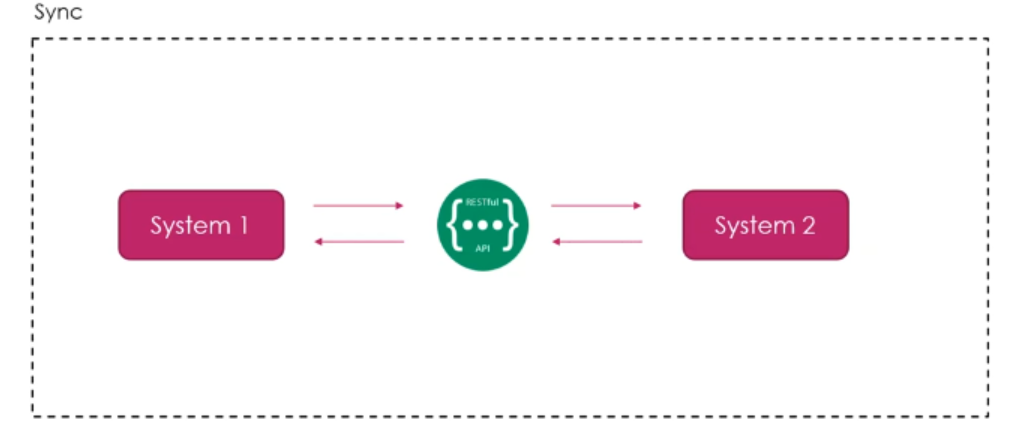


> Async Communication

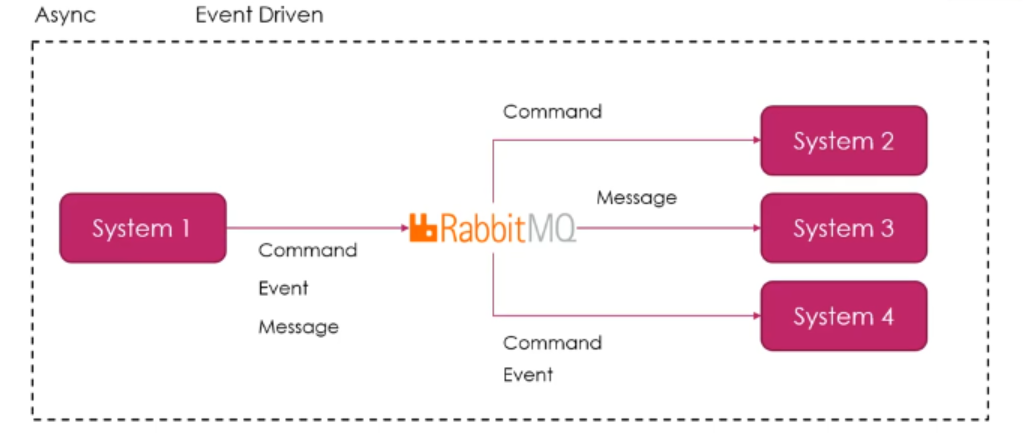

---

## 📊 3. Data Streaming and Real-Time Processing
- Ideal for handling continuous data flows.
- **Kafka** excels in real-time analytics, logs, and metrics pipelines.

---

## 🛡️ 4. Reliability and Fault Tolerance
- Messages are stored and acknowledged.
- Ensures **no data loss** if consumers fail or restart.

---

## ⏳ 5. Load Buffering
- Handles sudden traffic spikes.
- Queues messages until consumers are ready to process them.

---

## 🔁 6. Retry and Dead Letter Queues
- Failed messages can be retried or sent to a dead-letter queue.
- Helps with debugging and error tracking.

---

## ✉️ 7. Event-Driven Architectures
- Enables **event sourcing** and **reactive systems**.
- Example: "User registered" event triggers welcome email, etc.

---

## 🧩 Kafka vs RabbitMQ Comparison

| Feature               | **Apache Kafka**                        | **RabbitMQ**                             |
|-----------------------|------------------------------------------|-------------------------------------------|
| Message Model         | Pub/Sub (log-based)                      | Queue-based (message routing)             |
| Ordering              | Strong within partitions                 | FIFO in queues (if configured)            |
| Performance           | High throughput, scalable                | Lower latency, good for real-time tasks   |
| Persistence           | Messages stored on disk (log)            | Optional (persistent or transient queues) |
| Use Case Focus        | Streaming, big data, analytics           | Task queues, short-lived jobs             |
| Message Routing       | Topic-based (via partitions)             | Exchange types (direct, topic, fanout)    |

---

## 🛠 Use Case Examples

### Apache Kafka:
- Website clickstream analysis
- IoT sensor data pipelines
- Log aggregation
- Real-time analytics dashboards

### RabbitMQ:
- Email/task queues
- Real-time chat systems
- Background job processing
- Microservices task coordination

---
---

## ✅ Summary

| Feature        | **Apache Kafka**                                  | **RabbitMQ**                               |
| -------------- | ------------------------------------------------- | ------------------------------------------ |
| Type           | Distributed streaming platform / log-based broker | Traditional message broker / message queue |
| Protocols      | Custom binary protocol (Kafka protocol)           | AMQP, MQTT, STOMP, HTTP                    |
| Message Model  | **Publish-subscribe**, event streaming            | **Queue-based**, pub-sub via exchanges     |
| Use Case Focus | High-throughput, scalable, real-time analytics    | Reliable messaging, complex routing        |


### 🏗️ Architecture

| Feature             | **Kafka**                                     | **RabbitMQ**                                  |
| ------------------- | --------------------------------------------- | --------------------------------------------- |
| Storage             | Retains messages on disk (durable by default) | Messages are removed after being consumed     |
| Broker Clustering   | Built-in, highly scalable                     | Clustering supported, but complex to manage   |
| Consumers           | Pull-based (polling)                          | Push-based (messages are pushed to consumers) |
| Ordering Guarantees | Per partition                                 | Per queue                                     |


### ⚙️ Performance & Scalability

| Feature      | **Kafka**                                     | **RabbitMQ**                            |
| ------------ | --------------------------------------------- | --------------------------------------- |
| Throughput   | Very high (millions of messages/sec)          | Moderate                                |
| Latency      | Low, but higher than RabbitMQ in small bursts | Lower latency in short-lived messages   |
| Scalability  | Horizontally scalable with partitions         | Scaling is more complex and limited     |
| Backpressure | Clients pull at their pace                    | Can slow down or crash under heavy load |


### 🧠 Use Cases

| Use Case                        | **Kafka**                                   | **RabbitMQ**               |
| ------------------------------- | ------------------------------------------- | -------------------------- |
| Event sourcing                  | ✅ Yes                                       | 🚫 Not ideal               |
| Stream processing (e.g., Spark) | ✅ Ideal                                     | 🚫 Not suitable            |
| Task queue                      | 🚫 Not ideal (no auto delete after consume) | ✅ Perfect fit              |
| Real-time analytics             | ✅ Excellent                                 | 🚫 Less capable            |
| Complex routing (e.g., fanout)  | 🚫 Limited                                  | ✅ Very good with exchanges |


### 🛡️ Reliability & Durability

| Feature            | **Kafka**                               | **RabbitMQ**                                   |
| ------------------ | --------------------------------------- | ---------------------------------------------- |
| Acknowledgments    | Consumer commits offsets                | Ack/Nack model (message-by-message)            |
| Message durability | High (disk persisted, configurable TTL) | Optional durability, better for short messages |


### 📦 Ecosystem & Integrations

**Kafka integrates well with:**

 - Apache Spark, Flink, Hadoop, ksqlDB

 - Kafka Connect (source/sink integrations)

 - Ideal for data lakes and event-driven microservices


**RabbitMQ integrates well with:**

 - Languages with AMQP support

 - Backend applications, Celery (Python), Spring (Java)


Message brokers are essential in:
- Decoupling systems
- Improving scalability and resilience
- Handling real-time and asynchronous communication

Choose **Kafka** for **high-throughput streaming**, and **RabbitMQ** for **low-latency task distribution**.


# **🐰 RabbitMQ - Deep Dive**

## 📘 What is RabbitMQ?

RabbitMQ is a **message broker** that acts as a middleman for **sending and receiving messages between distributed systems**. It decouples the producer and consumer logic, enabling asynchronous communication and improved scalability, reliability, and fault tolerance in software systems.

RabbitMQ implements the **Advanced Message Queuing Protocol (AMQP)**, making it robust for complex messaging scenarios.

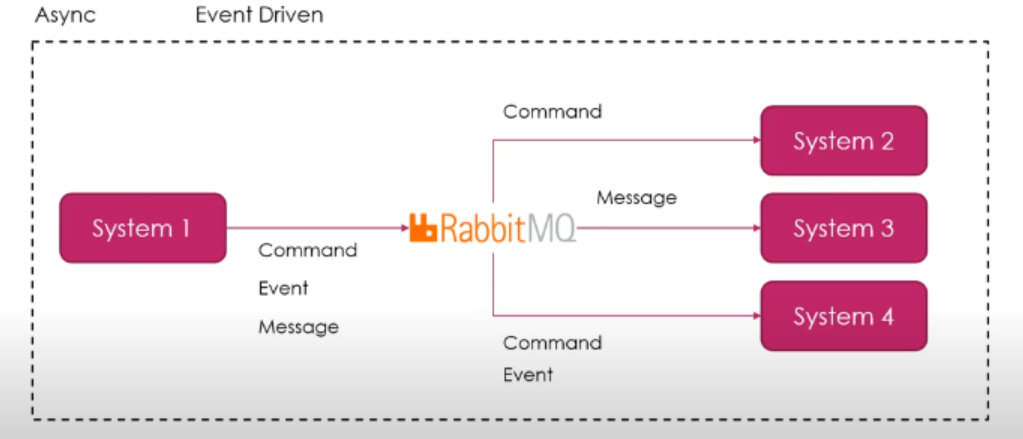

---

## 🧱 Core Components & Architecture

| Component        | Description |
|------------------|-------------|
| **Producer**     | An application that sends (publishes) messages to the broker. |
| **Queue**        | A buffer that stores messages. Consumers retrieve messages from queues. |
| **Consumer**     | An application that connects to the queue and processes messages. |
| **Broker**       | The RabbitMQ server which manages exchanges, queues, routing, etc. |
| **Exchange**     | Accepts messages from producers and routes them to queues. |
| **Binding**      | A rule that connects an exchange to a queue. |
| **Routing Key**  | A string used by the exchange to decide how to route messages to queues. |
| **Channel**      | A virtual connection inside a TCP connection. Efficient and lightweight. |
| **Virtual Host** | Logical containers in the broker for isolating exchanges, queues, and users. |


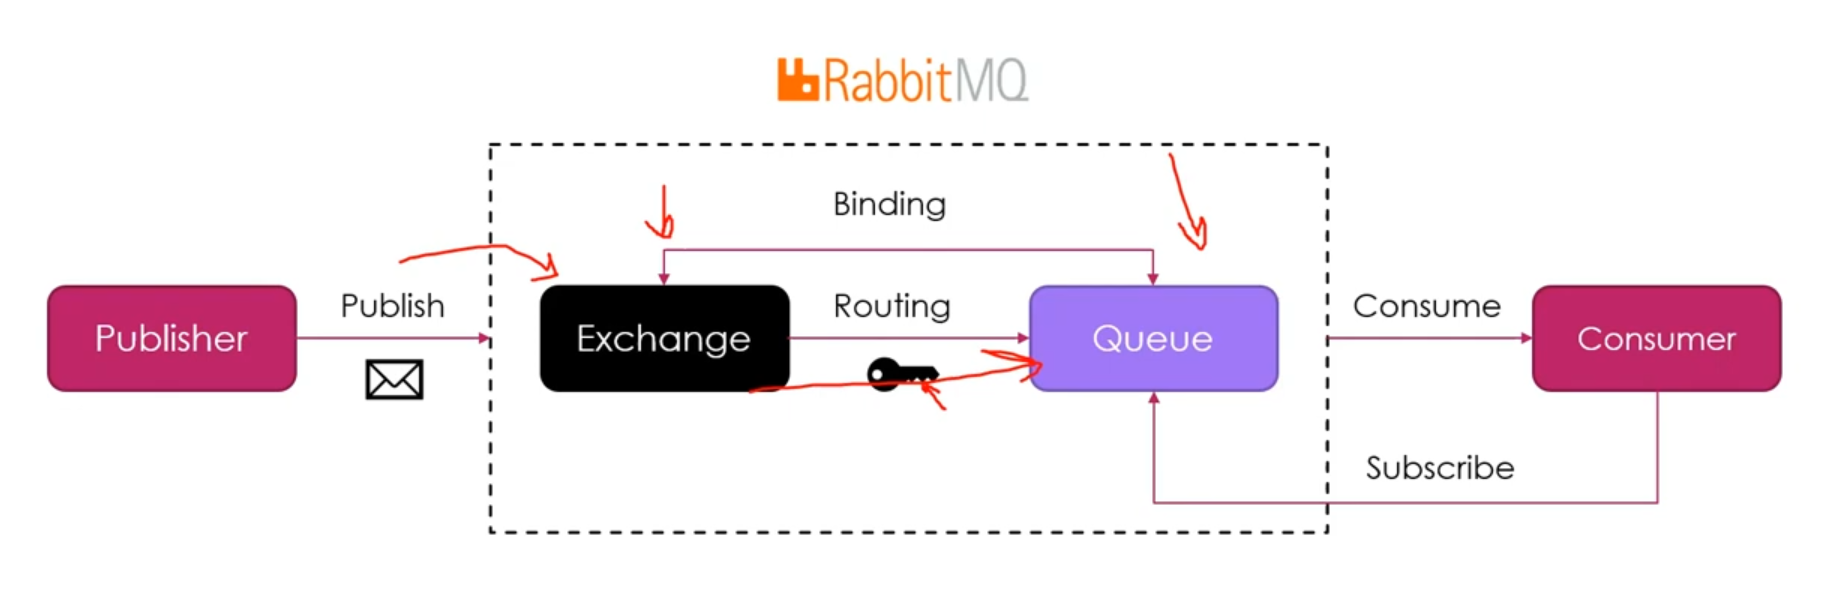

---

## 🔄 Exchange Types (Message Routing Strategies)

| Exchange Type | Description | Example Use |
|---------------|-------------|-------------|
| **Direct**    | Sends messages to the queue where the `routing_key` matches exactly. | Task distribution with specific labels like `email`, `log` |
| **Fanout**    | Broadcasts messages to **all** queues bound to it, **ignores routing keys**. | Notification systems, pub/sub architecture |
| **Topic**     | Routes messages using wildcard patterns in routing keys (`*` for one word, `#` for many). | Complex routing, e.g., `app.log.error`, `app.#` |
| **Headers**   | Routes based on **headers** instead of routing keys. Flexible but slower. | Routing based on multiple criteria like user ID, priority |

---

## 📈 Why Use RabbitMQ?

- ✅ **Decoupling:** Components don’t need to know about each other.
- ✅ **Scalability:** Can scale producers and consumers independently.
- ✅ **Reliability:** Messages can be persisted to disk.
- ✅ **Load Balancing:** Messages can be distributed across multiple consumers.
- ✅ **Asynchronous Processing:** Producers don’t wait for consumers to finish.

---

## 🧪 Example Use Cases

| Use Case | Description |
|----------|-------------|
| **Task Queues** | Background jobs like image resizing or report generation. |
| **Microservices Communication** | Loosely-coupled services exchanging messages. |
| **Logging System** | Aggregating logs from multiple sources. |
| **IoT Systems** | Handling streams of messages from devices. |
| **Order Processing** | Event-driven workflows in e-commerce systems. |

---

## ⚙️ Installation (Ubuntu)

```bash
sudo apt update
sudo apt install rabbitmq-server -y
sudo systemctl enable rabbitmq-server
sudo systemctl start rabbitmq-server
```

---

## 🌐 Enabling Management UI

> The Management Plugin gives you a web interface to manage queues, exchanges, connections, and more.

```bash
sudo rabbitmq-plugins enable rabbitmq_management

```

> - Access: http://localhost:15672
> - Default login: guest / guest



---

## 🧪 Python Example using pika (AMQP client)

**✅ Producer**

```python
import pika

# Connect to local RabbitMQ broker
connection = pika.BlockingConnection(pika.ConnectionParameters('localhost'))
channel = connection.channel()

# Ensure the queue exists
channel.queue_declare(queue='hello', durable=True)

# Publish message
channel.basic_publish(exchange='',
                      routing_key='hello',
                      body='Hello World!',
                      properties=pika.BasicProperties(
                          delivery_mode=2,  # Make message persistent
                      ))

print(" [x] Sent 'Hello World!'")
connection.close()

```

**✅ Consumer**

```python
import pika

# Callback function to handle received messages
def callback(ch, method, properties, body):
    print(f" [x] Received {body}")
    ch.basic_ack(delivery_tag=method.delivery_tag)  # Acknowledge message

# Connect to RabbitMQ
connection = pika.BlockingConnection(pika.ConnectionParameters('localhost'))
channel = connection.channel()

# Declare the queue (must match producer)
channel.queue_declare(queue='hello', durable=True)

# Fair dispatch: don't give more than one message to a worker at a time
channel.basic_qos(prefetch_count=1)

# Start consuming
channel.basic_consume(queue='hello', on_message_callback=callback)

print(' [*] Waiting for messages. To exit press CTRL+C')
channel.start_consuming()

```


---

## 📦 Docker Setup (Optional)

```yaml

# docker-compose.yml
version: '3'
services:
  rabbitmq:
    image: rabbitmq:3-management
    ports:
      - "5672:5672"       # AMQP port
      - "15672:15672"     # Web UI
    environment:
      RABBITMQ_DEFAULT_USER: admin
      RABBITMQ_DEFAULT_PASS: admin

```




---

## 🛡️ Message Acknowledgement & Durability

| Feature                | Description                                                  |
| ---------------------- | ------------------------------------------------------------ |
| **Durable Queue**      | Queue survives broker restart. Declared with `durable=True`. |
| **Persistent Message** | Message stored to disk using `delivery_mode=2`.              |
| **Manual Ack**         | Prevents data loss in case of consumer crash.                |


---

## 🧠 Best Practices

 - Use manual acknowledgments for critical tasks.

 - Keep your messages small and lightweight.

 - Monitor RabbitMQ using the management UI or Prometheus exporters.

 - Use exchanges to control routing logic instead of having many queues.

 - For performance, keep connections and channels open instead of reopening them for each message.


| Feature / Tech        | **MCP Server**                                                               | **RabbitMQ**                                                                |
| --------------------- | ---------------------------------------------------------------------------- | --------------------------------------------------------------------------- |
| 🔍 Full Name          | **Manufacturing Communication Protocol** (MCP) Server                        | RabbitMQ Message Broker                                                     |
| 🏷️ Category          | **Industrial protocol / communication server**                               | **Message Broker / Middleware**                                             |
| ⚙️ Purpose            | Facilitates communication between factory devices, PLCs, HMIs, SCADA systems | Transfers messages between software components/services                     |
| 📡 Communication Type | Often real-time, industrial protocol (Modbus, OPC UA, etc.)                  | Asynchronous messaging using AMQP protocol                                  |
| 🧩 Typical Use Case   | Industrial automation, machine communication in factories                    | Microservices, distributed systems, job queues, IoT messaging               |
| 📁 Data Format        | Binary, OPC UA tags, Modbus coils/registers, etc.                            | Text/binary messages in queues (e.g., JSON, XML, raw bytes)                 |
| 🔗 Connectivity       | Connects to machines, sensors, controllers (PLCs)                            | Connects to services, apps, APIs                                            |
| 🔄 Real-Time Capable  | Yes – designed for **real-time machine control**                             | Not suitable for hard real-time control, used for reliable background tasks |


**Example Use:**

A car factory has 50 robotic arms and sensors connected to a central server. The MCP Server collects data from these machines, allows controlling them remotely, and passes their status to a monitoring dashboard.

**Common protocols it may support:**

 - OPC UA/DA

 - Modbus TCP/RTU

 - PROFINET

 - Siemens S7

 - Mitsubishi MELSEC

# **📁 Folder Structure**


```plaintext
vision-monitoring-project/
├── README.md
├── docker-compose.yml
├── .env
├── requirements.txt
│
├── frame_reader/                         # Captures video frames
│   ├── main.py
│   ├── utils.py
│   └── config.py
│
├── detection_service/                   # YOLOv8 + logic to detect scooper, hand, pizza, violations
│   ├── app/
│   │   ├── consumer.py                  # FastAPI app
│   │   ├── inference.py                 # YOLOv8 wrapper
│   │   ├── violation_logic.py           # Custom rule-based logic
│   │   ├── models/
│   │   │   └── yolov8_model.pt
│   │   └── config.py
│   ├── main.py
│   ├── requirements.txt
│   └── Dockerfile
│
├── message_broker/                      # Kafka or RabbitMQ configurations
│   ├── docker/
│   │   ├── kafka/
│   │   │   └── docker-compose.kafka.yml
│   │   └── rabbitmq/
│   │       └── docker-compose.rabbitmq.yml
│   └── topics/
│       └── frame-topic.txt
│
├── streaming_service/                   # WebSocket / MJPEG / WebRTC server
│   ├── app/
│   │   ├── main.py
│   │   ├── websocket_server.py
│   │   ├── streamer.py                  # MJPEG / WebRTC
│   │   └── utils.py
│   └── Dockerfile
│
├── frontend/                            # React or Vue frontend
│   ├── public/
│   ├── src/
│   │   ├── components/
│   │   ├── views/
│   │   ├── App.jsx
│   │   └── index.jsx
│   ├── package.json
│   └── vite.config.js
│
├── shared/                              # Shared libraries between services
│   ├── logger.py
│   ├── schemas.py                       # Pydantic models, data schemas
│   └── constants.py
│
├── data/                                # Optional: recorded video or images for local testing
│   ├── test_video.mp4
│   └── samples/
│
├── deployments/                         # Kubernetes / Docker Swarm / CI/CD
│   ├── k8s/
│   └── ci-cd/
│
└── tests/                               # Unit and integration tests
    ├── test_frame_reader.py
    ├── test_detection_service.py
    ├── test_streaming.py
    └── test_utils.py
```

# **🍕 Computer Vision Scooper Violation Detection — Step-by-Step Implementation Guide**



## 🧠 Overview

This guide details how to implement a computer vision system to detect hygiene violations in a pizza store, specifically when workers fail to use a scooper to handle ingredients in Regions of Interest (ROIs).

The system will be built using a **microservices-based architecture** to ensure scalability, maintainability, and real-time performance.

---

## 🔧 Prerequisites

### 📦 System Requirements

* Python 3.8+
* Docker & Docker Compose
* Git
* Node.js + npm (for frontend)

```bash
(.venv) ferganey@ferganey-Inspiron-5570:~/GitHub/personal/Final_Learning_AI/07_Computer_Vision/04_EndtoEndProjects$ curl -fsSL https://deb.nodesource.com/setup_18.x | sudo -E bash -

sudo apt install -y nodejs

```

### 📁 Dataset & Models

* Annotated dataset on Roboflow
* Pretrained YOLOv8 model
* Sample test videos

---

## 📁 Step 1: Project Initialization

### 1.1 Folder Structure

Use the folder structure provided in the previous answer.

### 1.2 Setup Git Repository

```bash
git init vision-monitoring-project
cd vision-monitoring-project
```

---

## 🎥 Step 2: Frame Reader Microservice

### 2.1 Objective

Read frames from a video file or RTSP stream and send them to a message broker.

### 2.2 Implementation

* Use OpenCV to extract frames
* Publish each frame as a binary message to Kafka or RabbitMQ

```python
# frame_reader/main.py
import cv2, pika, json
# (Simplified code)
```

### 2.3 Dockerize

```dockerfile
# frame_reader/Dockerfile
FROM python:3.9
WORKDIR /app
COPY . .
RUN pip install -r requirements.txt
CMD ["python", "main.py"]
```

---

## 📨 Step 3: Message Broker Setup

### 3.1 Choose a Broker

* Kafka (for high performance)
* RabbitMQ (easier setup)

### 3.2 Docker Compose Service

```yaml
# In docker-compose.yml
rabbitmq:
  image: rabbitmq:3-management
  ports:
    - "5672:5672"
    - "15672:15672"
```

---

## 🔍 Step 4: Detection Service

### 4.1 Objective

* Subscribe to the broker
* Run YOLOv8 inference on the frame
* Apply business logic to detect violations
* Save metadata and publish to streaming

### 4.2 Implementation

* Use Ultralytics YOLOv8 + PyTorch
* Define logic: `hand in ROI and no scooper = violation`
* Return: bounding boxes, labels, timestamp, violation status

```python
# detection_service/app/inference.py
from ultralytics import YOLO
model = YOLO('yolov8.pt')
# Detect objects
```

### 4.3 REST API

Use FastAPI to expose an endpoint for metadata.

### 4.4 Dockerize

Create Dockerfile and include all dependencies.

---

## 🌐 Step 5: Streaming Service

### 5.1 Objective

* Send annotated video stream to frontend
* Provide REST API for metadata

### 5.2 Implementation Options

* MJPEG (simplest)
* WebSocket (recommended)
* WebRTC (most performant)

Use FastAPI or Flask for both WebSocket & REST endpoints.

---

## 💻 Step 6: Frontend

### 6.1 Objective

* Display live video with bounding boxes
* Highlight ROIs
* Show violation count and alerts

### 6.2 Tools

* React.js (preferred)
* Socket.IO or WebSocket client

### 6.3 Sample UI Features

* Bounding boxes
* Violation alerts in red
* Metadata panel

---

## 🧪 Step 7: Testing

### 7.1 Unit Testing

* Test frame extraction, detection logic

### 7.2 Integration Testing

* Run all services together with test video
* Confirm correct detection and alerts

### 7.3 Manual Testing

* Use sample test videos:

  * `Sah w b3dha ghalt.mp4`
  * `Sah w b3dha ghalt (2).mp4`

---

## 🚀 Step 8: Deployment

### 8.1 Docker Compose

Add all services to `docker-compose.yml`

```yaml
version: '3.8'
services:
  frame_reader:
    build: ./frame_reader
  detection_service:
    build: ./detection_service
  streaming_service:
    build: ./streaming_service
  frontend:
    build: ./frontend
  rabbitmq:
    image: rabbitmq:3-management
```

### 8.2 Run All Services

```bash
docker-compose up --build
```

---

## ✅ Deliverables

* Functional microservices-based system
* Live frontend showing bounding boxes, ROIs, and violation count
* REST API for metadata
* Source code with documentation
* Recorded video of system working

---

## 🌟 Bonus Points

* Add Grafana + Prometheus for monitoring
* Log violations to a PostgreSQL/SQLite DB
* Use Redis for frame caching
* Add authentication to frontend/backend

---

Need help writing any specific service code or config? I can help build those next.


## **YOLOv8**

### ✅ Why YOLOv8 Was Chosen:


| Reason                             | Explanation                                                                                                                                                                         |
| ---------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 🔧 **Maturity & Stability**        | YOLOv8 is mature and **well-tested** in production environments. It offers a solid balance between performance, accuracy, and ease of use.                                          |
| 🚀 **Ultralytics Support**         | YOLOv8 is officially released and maintained by **Ultralytics**, which provides a **user-friendly Python API**, command-line tools, pretrained models, and excellent documentation. |
| ⚙️ **FastAPI Compatibility**       | YOLOv8 integrates easily with Python-based backends like **FastAPI**, which is used in your detection service.                                                                      |
| 📦 **Docker-friendly**             | YOLOv8 works seamlessly in Docker, including CUDA support for GPU acceleration. Many official containers already exist.                                                             |
| 🧠 **ONNX/Torch Export Support**   | You can export YOLOv8 models to ONNX, TensorRT, or CoreML easily, which is great for deployment on edge devices or embedded Linux systems.                                          |
| 📈 **Speed vs Accuracy Trade-off** | It has great performance for real-time detection (30–60+ FPS on GPU) with models from `n`, `s`, `m`, `l`, to `x` for different hardware capabilities.                               |



### 🔄 Why Not Use the Very Latest YOLO (e.g. YOLOv9)?

| Concern                                  | Explanation                                                                                                                                          |
| ---------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------- |
| 🔄 **Still Evolving**                    | YOLOv9 is relatively **new** and still undergoing community and production testing. It may have **less mature APIs** and integration guides.         |
| 🔧 **Fewer Prebuilt Integrations**       | YOLOv9 might lack **plug-and-play support** with Ultralytics tools, FastAPI, Docker, or TensorRT export pipelines (depending on the implementation). |
| 🐛 **More Bugs and Less Community Help** | Being newer, it could come with **undocumented behaviors**, **breaking changes**, or **fewer solutions online**.                                     |
| ⚠️ **Not yet widely adopted**            | Most tutorials, pretrained models, and optimization examples are still centered around YOLOv8.                                                       |


### 🧪 But If You Want to Use YOLOv9 or Alternatives...

If you explicitly want to use YOLOv9, YOLO-World, or PP-YOLOE, we can:

 - Integrate the latest model manually using PyTorch or ONNX

 - Handle custom input/output preprocessing

 - Convert weights if needed

 - Optimize the pipeline with TensorRT if targeting embedded or edge devices

> 
> 🧠 TL;DR:
> YOLOv8 was chosen because it’s production-ready, well-documented, and easy to integrate into modern Python/Docker/FastAPI systems. The latest YOLO models might be better on paper, but practical deployment favors YOLOv8 right now.
> 



## 📁 Step 1: Project Initialization




### 1.1 Folder Structure

Use the folder structure provided in the previous answer.

### 1.2 Setup Git Repository

```bash
git init vision-monitoring-project
cd vision-monitoring-project
```



## 🎥 Step 2: Frame Reader Microservice



### 2.1 Objective

Build a microservice that:

 - Reads frames from a video file or RTSP stream.

 - Publishes frames (as JPEG-encoded bytes) to a message broker (RabbitMQ or Kafka).


### 2.2 Dir Structure

```plaintext
frame_reader/
├── Dockerfile
├── main.py
├── requirements.txt
├── config.py
└── utils.py
```

### 2.2 Implementation

* Use OpenCV to extract frames
* Publish each frame as a binary message to Kafka or RabbitMQ

```python
# frame_reader/main.py
import cv2, pika, json
# (Simplified code)
```

### 2.3 Dockerize

```dockerfile
# frame_reader/Dockerfile
FROM python:3.9
WORKDIR /app
COPY . .
RUN pip install -r requirements.txt
CMD ["python", "main.py"]
```

---


**Requirement.txt**

```
opencv-python
pika  # For RabbitMQ
# or confluent-kafka if using Kafka
```

**⚙️ config.py**
```bash

import os

RABBITMQ_HOST = os.getenv('RABBITMQ_HOST', 'localhost')
RABBITMQ_QUEUE = os.getenv('RABBITMQ_QUEUE', 'frame_queue')
RABBITMQ_EXCHANGE = os.getenv('RABBITMQ_EXCHANGE', 'video_exchange')
RABBITMQ_ROUTING_KEY = os.getenv('RABBITMQ_ROUTING_KEY', 'video_frame')
VIDEO_SOURCE = os.getenv('VIDEO_SOURCE', 'pizza.mp4')

```


**🛠️ utils.py**
```bash
import cv2

def encode_frame(frame):
    success, buffer = cv2.imencode('.jpg', frame)
    return buffer.tobytes() if success else None



```

**🧠 main.py**
```bash
# Importing OpenCV for video capture and frame processing
import cv2
# Importing pika library for interacting with RabbitMQ message broker
import pika
# Importing time module to control the frame publishing rate
import time
# Importing configuration variables (RabbitMQ host, queue name, and video source)
from config import (
    RABBITMQ_HOST,
    RABBITMQ_QUEUE,
    RABBITMQ_EXCHANGE,
    RABBITMQ_ROUTING_KEY,
    VIDEO_SOURCE
)

# Importing a utility function to encode frames before sending
from utils import encode_frame
import logging


# Setup logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')



# Function to establish connection and setup the RabbitMQ channel
def setup_rabbitmq(retries=10, delay=3):
    for i in range(retries):
        try:    
            # Create a blocking connection to RabbitMQ server
            connection = pika.BlockingConnection(pika.ConnectionParameters(host=RABBITMQ_HOST))
            # Create a channel on the connection to send messages
            channel = connection.channel()


            # Declare exchange with type (e.g., direct)
            channel.exchange_declare(exchange=RABBITMQ_EXCHANGE, exchange_type='direct', durable=True)

            # Declare queue with optional settings
            channel.queue_declare(queue=RABBITMQ_QUEUE, durable=True)


            # Bind queue to exchange with a routing key
            channel.queue_bind(exchange=RABBITMQ_EXCHANGE, queue=RABBITMQ_QUEUE, routing_key=RABBITMQ_ROUTING_KEY)

            logging.info(f"Connected to RabbitMQ at {RABBITMQ_HOST}")

            # Return the channel to be used for publishing
            return connection, channel
        except pika.exceptions.AMQPConnectionError as e:
            logging.warning(f"Connection failed (attempt {i+1}/{retries}), retrying in {delay}s...")
            time.sleep(delay)
    logging.error("Failed to connect to RabbitMQ after several attempts.")
    raise pika.exceptions.AMQPConnectionError("Could not connect to RabbitMQ")  


# Function to capture frames from video and publish them to RabbitMQ
def read_and_publish_frames():
    # Open the video source (file path or RTSP stream)
    cap = cv2.VideoCapture(VIDEO_SOURCE)
    if not cap.isOpened():
        logging.error(f"Failed to open video source: {VIDEO_SOURCE}")
        return
        
    # Setup RabbitMQ channel
    connection, channel = setup_rabbitmq()
    
    
    try:
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                logging.info("End of video stream or error occurred.")
                break

            encoded = encode_frame(frame)
            if not encoded:
                logging.warning("Frame encoding failed, skipping frame.")
                continue

            # Publish the encoded frame
            channel.basic_publish(
                exchange=RABBITMQ_EXCHANGE,
                routing_key=RABBITMQ_ROUTING_KEY,
                body=encoded,
                properties=pika.BasicProperties(delivery_mode=2)  # Persistent
            )

            frame_count += 1
            if frame_count % 30 == 0:
                logging.info(f"Published {frame_count} frames...")

            time.sleep(0.03)  # Approx. 30 FPS

    except Exception as e:
        logging.exception("An error occurred while reading and publishing frames.")
    finally:
        cap.release()
        connection.close()
        logging.info("Resources released and RabbitMQ connection closed.")


# Main block to run the function if the script is executed directly
if __name__ == "__main__":
    read_and_publish_frames()

```

**🐳 Dockerfile**
```dockerfile
# Use a slim Python base image
FROM demisto/opencv:1.0.0.3252732


# Set working directory
WORKDIR /app


# Copy only requirements first, to cache dependencies if unchanged
COPY requirements.txt .

# Install Python dependencies
RUN pip install --no-cache-dir -r requirements.txt

# Now copy the rest of the app code
COPY . .

# Default command to run the microservice
CMD ["python", "main.py"]



```

**BUILD and RUN**
```bash
cd frame_reader
docker build -t frame_reader:latest .
docker run --network="host" frame_reader


```

> Or integrate into docker-compose.yml with the rest of your microservices.

> ✅ Verification Checklist
> - ✅ Frames are being read from the video source.
> 
> - ✅ Messages (JPEG frames) are sent to the message broker queue.
> 
> - ✅ Each frame is encoded and published with minimal delay (~30 FPS).


## 📨 Step 3: Message Broker Setup



### 3.1 Choose a Broker

* Kafka (for high performance)
* RabbitMQ (easier setup)

### 3.2 Docker Compose Service

```yaml
# In docker-compose.yml
rabbitmq:
  image: rabbitmq:3-management
  ports:
    - "5672:5672"
    - "15672:15672"
```

---


## 🔍 Step 4: Detection Service




### 4.1 Objective

* Subscribe to the message broker.

* Run YOLOv8 inference on incoming video frames.

* Apply violation detection logic:
        → If hand enters ROI and no scooper used, mark as violation.

* Save metadata (bounding boxes, labels, timestamps, violations).

* Publish processed frames & results to the Streaming Service.



```plaintext

detection_service/
├── app/
│   ├── consumer.py            # Subscribes to RabbitMQ and triggers inference pipeline
│   ├── inference.py           # Loads YOLOv8 model and performs object detection
│   ├── violation_logic.py     # Rule-based violation detection logic
│   ├── models/
│   │   └── yolov8_model.pt    # Pretrained YOLOv8 model
│   └── config.py              # Environment config and settings
├── main.py                    # Entry point to launch FastAPI app and consumer
├── requirements.txt           # Required Python dependencies
├── Dockerfile                 # Docker image for detection service
```

### 4.2 Implementation

**🧩 Technologies Used**

 - Ultralytics YOLOv8 (ultralytics package)

 - PyTorch for backend

 - FastAPI to serve metadata

 - RabbitMQ / Kafka consumer for frame input


* Use Ultralytics YOLOv8 + PyTorch
* Define logic: `hand in ROI and no scooper = violation`
* Return: bounding boxes, labels, timestamp, violation status

```python
# detection_service/app/inference.py
from ultralytics import YOLO
model = YOLO('yolov8.pt')
# Detect objects
```

### 4.3 REST API

Use FastAPI to expose an endpoint for metadata.

### 4.4 Dockerize

Create Dockerfile and include all dependencies.



```python
# vision-monitoring-project/detection_service/

# -----------------------------------------
# detection_service/app/config.py
# -----------------------------------------

import os

RABBITMQ_HOST = os.getenv("RABBITMQ_HOST", "localhost")
RABBITMQ_QUEUE = os.getenv("RABBITMQ_QUEUE", "frame_queue")
RABBITMQ_EXCHANGE = os.getenv("RABBITMQ_EXCHANGE", "video_exchange")
RABBITMQ_ROUTING_KEY = os.getenv("RABBITMQ_ROUTING_KEY", "video_frame")
MODEL_PATH = os.getenv("MODEL_PATH", "app/models/yolov8_model.pt")
ROI_ZONES = [(100, 100, 300, 300)]  # Example ROI bounding box for scooper zone
# -----------------------------------------
# detection_service/app/inference.py
# -----------------------------------------
from ultralytics import YOLO
import cv2
import numpy as np

class InferenceEngine:
    def __init__(self, model_path):
        self.model = YOLO(model_path)

    def detect(self, image_bytes):
        np_arr = np.frombuffer(image_bytes, np.uint8)
        image = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
        results = self.model(image, conf=0.3)[0]

        detections = []
        for box in results.boxes:
            label = results.names[int(box.cls)]
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            detections.append({
                "label": label,
                "box": [x1, y1, x2, y2],
                "conf": float(box.conf)
            })
        return detections


# -----------------------------------------
# detection_service/app/violation_logic.py
# -----------------------------------------
def check_violation(detections, roi_zones):
    hands = [d for d in detections if d['label'] == 'hand']
    scoopers = [d for d in detections if d['label'] == 'scooper']
    violations = []

    for roi in roi_zones:
        rx1, ry1, rx2, ry2 = roi
        hand_in_roi = any(
            rx1 < box[0] < rx2 and ry1 < box[1] < ry2
            for d in hands for box in [d['box']]
        )
        scooper_present = any(
            rx1 < box[0] < rx2 and ry1 < box[1] < ry2
            for d in scoopers for box in [d['box']]
        )

        if hand_in_roi and not scooper_present:
            violations.append({"roi": roi, "violation": True})
    return violations


# -----------------------------------------
# detection_service/app/consumer.py
# -----------------------------------------
import pika, json, os
from fastapi import FastAPI
from app.inference import InferenceEngine
from app.violation_logic import check_violation
import cv2
import time
from app.config import *

app = FastAPI()
inference = InferenceEngine(MODEL_PATH)

OUTPUT_PATH = os.getenv("OUTPUT_PATH", "/processed_frames")
os.makedirs(OUTPUT_PATH, exist_ok=True)

@app.on_event("startup")
def startup_event():
    conn = pika.BlockingConnection(pika.ConnectionParameters(host=RABBITMQ_HOST))
    ch = conn.channel()
    ch.queue_declare(queue=RABBITMQ_QUEUE, durable=True)

    def callback(ch, method, props, body):
        detections = inference.detect(body)
        violations = check_violation(detections, ROI_ZONES)

        # Save latest JPEG from body
        timestamp = int(time.time() * 1000)
        frame_file = os.path.join(OUTPUT_PATH, f"{timestamp}.jpg")
        with open(frame_file, "wb") as fp:
            fp.write(body)

        # Update metadata.json
        metadata = {
            "timestamp": timestamp,
            "detections": detections,
            "violations": violations,
            "latest_frame": os.path.basename(frame_file),
        }
        with open(os.path.join(OUTPUT_PATH, "metadata.json"), "w") as fp:
            json.dump(metadata, fp)

    ch.basic_consume(queue=RABBITMQ_QUEUE, on_message_callback=callback, auto_ack=True)
    print("Detection service listening for frames...")
    ch.start_consuming()


# -----------------------------------------
# detection_service/main.py
# -----------------------------------------
from fastapi import FastAPI
from app.consumer import app as detection_app

app = detection_app


# -----------------------------------------
# detection_service/requirements.txt
# -----------------------------------------
ultralytics
opencv-python
numpy
pika
fastapi
uvicorn

```
```dockerfile
# -----------------------------------------
# detection_service/Dockerfile
# -----------------------------------------
FROM demisto/opencv:1.0.0.3252732

WORKDIR /app

COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

COPY . .

CMD ["uvicorn", "main:app", "--host", "0.0.0.0", "--port", "8000"]

```
---


## 🌐 Step 5: Streaming Service




### 5.1 Objective

* Send annotated video stream to frontend
* Provide REST API for metadata

### 5.2 Implementation Options

* MJPEG (simplest)
* WebSocket (recommended)
* WebRTC (most performant)

Use FastAPI or Flask for both WebSocket & REST endpoints.

---


**📁 Folder Structure (Updated for Simplicity and Integration)**

```plaintext
streaming_service/
├── app/
│   ├── main.py                # FastAPI entry point
│   ├── streamer.py            # MJPEG and WebSocket stream logic
│   ├── websocket_server.py    # WebSocket server setup
│   ├── utils.py               # Helper functions (frame reading, encoding)
│   ├── metadata_store.py      # Optional: local JSON metadata store
│   └── config.py              # Environment config
├── requirements.txt
└── Dockerfile
```

---

**🔧 `requirements.txt`**
```text
fastapi
uvicorn
python-multipart
opencv-python
watchdog
websockets
```

---

**⚙️ `config.py`**

```python
import os

FRAMES_PATH = os.getenv("FRAMES_PATH", "shared/processed_frames")
STREAM_PORT = int(os.getenv("STREAM_PORT", 8000))
STREAM_FPS = float(os.getenv("STREAM_FPS", 25))
METADATA_PATH = os.getenv("METADATA_PATH", "shared/processed_frames/metadata.json")


```

---

**🔧 `utils.py`**

```python
import cv2
import os
import json
from fastapi.responses import StreamingResponse


def get_sorted_frames(folder):
    files = sorted(
        [f for f in os.listdir(folder) if f.endswith(".jpg")],
        key=lambda x: os.path.getmtime(os.path.join(folder, x))
    )
    return files

def frame_generator(folder):
    while True:
        for file in get_sorted_frames(folder):
            frame_path = os.path.join(folder, file)
            with open(frame_path, "rb") as f:
                yield (b"--frame\r\nContent-Type: image/jpeg\r\n\r\n" + f.read() + b"\r\n")


def get_latest_metadata(metadata_path):
    try:
        with open(metadata_path, "r") as f:
            return json.load(f)
    except Exception:
        return {}
```

---

**🚀 `streamer.py`**

```python
from fastapi import APIRouter
from fastapi.responses import StreamingResponse, JSONResponse
from app.config import FRAMES_PATH, METADATA_PATH
from app.utils import frame_generator, get_latest_metadata

router = APIRouter()

@router.get("/video")
def stream_video():
    """
    Stream MJPEG video composed of latest frames from the FRAMES_PATH directory.
    """
    return StreamingResponse(
        frame_generator(FRAMES_PATH),
        media_type="multipart/x-mixed-replace; boundary=frame"
    )

@router.get("/metadata")
def metadata():
    """
    Serve the latest metadata JSON from METADATA_PATH.
    """
    data = get_latest_metadata(METADATA_PATH)
    return JSONResponse(content=data)


```

---

**`websocket.py`**
```python
from fastapi import APIRouter, WebSocket
import os
import time
import cv2
from app.config import FRAMES_PATH
from app.utils import get_sorted_frames

router = APIRouter()

@router.websocket("/ws")
async def websocket_endpoint(websocket: WebSocket):
    await websocket.accept()
    last_sent = None
    try:
        while True:
            frames = get_sorted_frames(FRAMES_PATH)
            if frames and frames[-1] != last_sent:
                frame_path = os.path.join(FRAMES_PATH, frames[-1])
                with open(frame_path, "rb") as f:
                    await websocket.send_bytes(f.read())
                last_sent = frames[-1]
            time.sleep(0.1)
    except Exception as e:
        print(f"WebSocket closed: {e}")
```        

---

**🌐 `main.py`**

```python
from fastapi import FastAPI
from app import streamer, websocket_server

app = FastAPI(title="Streaming Service")

# MJPEG Streaming Endpoints
app.include_router(streamer.router)

# WebSocket Streaming Endpoints
app.include_router(websocket_server.router)

# Health Check Endpoint
@app.get("/")
def root():
    return {"message": "Streaming service is up"}


```

---

**🐳 `Dockerfile`**

```dockerfile
FROM demisto/opencv:1.0.0.3252732
WORKDIR /app
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt
COPY ./app ./app
CMD ["uvicorn", "app.main:app", "--host", "0.0.0.0", "--port", "8080"]

```

---

**🔗 Add to `docker-compose.yml`**

```yaml
  streaming_service:
    build: ./streaming_service
    container_name: streaming_service
    depends_on:
      detection_service:
        condition: service_started
    environment:
      - FRAMES_PATH=/processed_frames
      - STREAM_PORT=8000
    ports:
      - "8000:8000"
    volumes:
      - ./streaming_service:/app
      - ./processed_frames:/processed_frames
```

---

### **✅ After Running Docker Compose**

Open your browser and navigate to:
```
http://localhost:8000/video
```
To see the MJPEG stream from processed frames.

Let me know if you also want:
- WebSocket-based video stream
- REST API to serve latest detection metadata


| Requirement                                                     | Handled By          | Status                                          |
| --------------------------------------------------------------- | ------------------- | ----------------------------------------------- |
| 1. **Ingest video (file or RTSP)**                              | `frame_reader`      | ✅                                               |
| 2. **Identify ROIs and interactions**                           | `detection_service` | ✅                                               |
| 3. **Check for scooper usage or lack thereof**                  | `detection_service` | ✅                                               |
| 4. **Flag violations (hand at ROI without scooper → on pizza)** | `detection_service` | ✅                                               |
| 5. **Handle cleaning (hand in ROI but didn’t take anything)**   | `detection_service` | ✅ If logic implemented properly                 |
| 6. **Handle multi-person scenarios (two workers at table)**     | `detection_service` | ✅ If object tracking & multi-person logic added |
| Save violation info (frame path, bbox, label, timestamp) to DB  | `detection_service` | ✅                                               |
| Send detection metadata to streaming service                    | `detection_service` | ✅ Via shared folder or message                  |


## **Now our system consisting of:**



 - frame_reader (publishes frames to RabbitMQ)

 - detection_service (consumes frames, performs detection)

 - streaming_service (serves metadata and video stream)

 - docker-compose.yml (orchestrates services)

```mermaid
graph TD
    A[pizza.mp4 in ./data] -->|read + encode| B(frame_reader)
    B -->|sends frame via RabbitMQ| C(detection_service)
    C -->|performs detection + violation| D[optional: save/stream/metadata]
    D -->|reads processed frames| E(streaming_service)
```

**✅ Functional Flow Verification**'

 - ✅ Frame Reader
 
Captures → encodes JPEG → sends via RabbitMQ

Config: all environment variables wired properly

 - ✅ Detection Service
 
Consumes frames from RabbitMQ

Performs YOLO inference, ROI check

Prints detection + violations

 - ✅ Streaming Service
 
Reads JPEGs from folder and streams via MJPEG or WebSocket


**Suggestions for Production Robustness**


| Area          | Recommendation                                                                 |
| ------------- | ------------------------------------------------------------------------------ |
| Frame Store   | Save JPEG frames into `shared/processed_frames` from detection (not shown yet) |
| Metadata      | `detection_service` should write a `metadata.json` to `/processed_frames`      |
| Graceful Exit | Add signal handling to consumers for clean shutdown                            |
| Logging       | Add persistent logging to files under `./logs`                                 |
| Validation    | Add schema validation to `metadata` endpoint                                   |
| Monitoring    | Add `/health` endpoints or metrics for Prometheus in future                    |


**Once everything is built:**

Access:

 - RabbitMQ UI: http://localhost:15672

 - Stream API: http://localhost:8000/video

 - Metadata API: http://localhost:8000/metadata

 - Dashboard: http://localhost:3000



## 💻 Step 6: Frontend and Logger




### 6.1 Objective

* Display live video with bounding boxes
* Highlight ROIs
* Show violation count and alerts

```plaintext
├── frontend/                      # React frontend (with Vite)
│   ├── public/
│   │   └── index.html
│   ├── src/
│   │   ├── components/            # UI components (VideoPlayer, MetadataPanel, etc.)
│   │   ├── views/                 # Pages like Dashboard.jsx
│   │   ├── App.jsx
│   │   └── main.jsx               # entrypoint
│   ├── package.json
│   └── vite.config.js

├── shared/                        # Shared utilities across services
│   ├── logger.py                  # Logging configuration
│   ├── schemas.py                # Pydantic models (shared across backend services)
│   └── constants.py              # ROI zones, frame paths, etc.



├── detection_service/
│   └── app/
│       └── use shared/schemas.py and logger.py

├── streaming_service/
│   └── app/
│       └── use shared/logger.py, constants.py
```



### 6.2 Tools

* React.js (preferred)
* Socket.IO or WebSocket client

### 6.3 Sample UI Features

* Bounding boxes
* Violation alerts in red
* Metadata panel

---

**VideoPlayer.jsx**
```jsx
import React, { useEffect, useRef } from 'react';

function VideoPlayer({ metadata }) {
  const videoRef = useRef();
  const canvasRef = useRef();

  useEffect(() => {
    const drawBoxes = () => {
      const canvas = canvasRef.current;
      const ctx = canvas.getContext("2d");
      const img = videoRef.current;

      canvas.width = img.width;
      canvas.height = img.height;

      ctx.clearRect(0, 0, canvas.width, canvas.height);
      metadata?.detections?.forEach(det => {
        const [x, y, w, h] = det.bbox;
        ctx.strokeStyle = det.violation ? 'red' : 'lime';
        ctx.lineWidth = 2;
        ctx.strokeRect(x, y, w, h);
        ctx.fillText(det.label, x, y - 5);
      });

      requestAnimationFrame(drawBoxes);
    };

    const img = videoRef.current;
    img.onload = () => drawBoxes();
  }, [metadata]);

  return (
    <div style={{ position: 'relative', width: '640px' }}>
      <img ref={videoRef} src="http://localhost:8000/video" alt="Stream" style={{ width: '100%' }} />
      <canvas ref={canvasRef} style={{ position: 'absolute', top: 0, left: 0 }} />
    </div>
  );
}

export default VideoPlayer;


```



**MetadataPanel.jsx**
```jsx

function MetadataPanel({ metadata }) {
  return (
    <div>
      <h3>Metadata</h3>
      <pre>{JSON.stringify(metadata, null, 2)}</pre>
      {metadata.violations?.length > 0 && (
        <div style={{ color: 'red' }}>
          🚨 {metadata.violations.length} Violation(s) Detected!
        </div>
      )}
    </div>
  );
}

```



**App.jsx**
```jsx
import React, { useEffect, useState } from 'react';
import VideoPlayer from './components/VideoPlayer';
import MetadataPanel from './components/MetadataPanel';

function App() {
  const [metadata, setMetadata] = useState({});

  useEffect(() => {
    const ws = new WebSocket("ws://localhost:8000/ws");

    ws.onmessage = () => {
      fetch("http://localhost:8000/metadata")
        .then(res => res.json())
        .then(setMetadata);
    };

    return () => ws.close();
  }, []);

  return (
    <div>
      <h1>🍕 Pizza Store Monitor</h1>
      <VideoPlayer metadata={metadata} />
      <MetadataPanel metadata={metadata} />
    </div>
  );
}

export default App;


```



**vite.config.js**
```js
import { defineConfig } from 'vite'
import react from '@vitejs/plugin-react'

export default defineConfig({
  plugins: [react()],
  server: {
    port: 3000,
  }
})


```



**shared/logger.py**
```python
import logging

def get_logger(name):
    logger = logging.getLogger(name)
    handler = logging.StreamHandler()
    formatter = logging.Formatter('[%(levelname)s] %(asctime)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)
    return logger


```



**shared/schemas.py**
```python
from pydantic import BaseModel
from typing import List

class Detection(BaseModel):
    label: str
    bbox: List[int]  # [x, y, w, h]
    violation: bool = False

class Metadata(BaseModel):
    timestamp: int
    detections: List[Detection]
    violations: List[str]
    latest_frame: str


```



**shared/constants.py**
```python
FRAMES_PATH = "/processed_frames"
METADATA_PATH = "/processed_frames/metadata.json"
ROI_ZONES = {
    "zone1": [(10, 10), (200, 200)],
    "zone2": [(300, 100), (500, 300)]
}



```

**frontend/Dockerfile**

```dockerfile
# Step 1: Build the app
FROM node:20 AS builder
WORKDIR /app
COPY package.json vite.config.js ./
COPY src ./src
COPY public ./public
RUN npm install && npm run build

# Step 2: Serve with Nginx
FROM nginx:alpine
COPY --from=builder /app/dist /usr/share/nginx/html
COPY nginx.conf /etc/nginx/conf.d/default.conf

EXPOSE 80
CMD ["nginx", "-g", "daemon off;"]
```

**frontend/nginx.conf**

```conf
server {
    listen 80;
    server_name localhost;

    location / {
        root /usr/share/nginx/html;
        index index.html;
        try_files $uri $uri/ /index.html;
    }
}

```


```plaintext
+------------------+       +--------------------+       +-------------------+       +-------------------+       +----------------+
| Frame Reader     | ----> | Message Broker     | ----> | Detection Service | ----> | Streaming Service | ----> | Frontend (UI)  |
+------------------+       +--------------------+       +-------------------+       +-------------------+       +----------------+
        ^                                                                                                                    |
        |                                                                                                                    |
        +--------------------------- Docker Compose / Orchestration Layer --------------------------------------------------+
```


```plaintext

[Camera] 
   ↓ (RTSP Feed)
[Frame Reader Service] 
   ↓ (Base64 Frames)
[Message Broker (RabbitMQ)] 
   ↓
[Detection Service (YOLO + Violation Logic)] 
   ↙                ↘
[Database]        [Streaming Service]
                       ↓
                   [Frontend UI]



```

## 🧪 Step 7: Testing




### 7.1 Unit Testing

* Test frame extraction, detection logic

### 7.2 Integration Testing

* Run all services together with test video
* Confirm correct detection and alerts

### 7.3 Manual Testing

* Use sample test videos:

  * `Sah w b3dha ghalt.mp4`
  * `Sah w b3dha ghalt (2).mp4`

---


## 🚀 Step 8: Deployment




### 8.1 Docker Compose

Add all services to `docker-compose.yml`

```yaml
version: '3.8'
services:
  frame_reader:
    build: ./frame_reader
  detection_service:
    build: ./detection_service
  streaming_service:
    build: ./streaming_service
  frontend:
    build: ./frontend
  rabbitmq:
    image: rabbitmq:3-management
```

### 8.2 Run All Services

```bash
docker-compose up --build
```

---


# **🔁 Architecture Diagram (Logical)**



```plaintext
                ┌─────────────────────┐
                │   Camera / RTSP     │
                └────────┬────────────┘
                         │
                ┌────────▼─────────┐
                │  Frame Reader    │
                │ (OpenCV + Pub)   │
                └────────┬─────────┘
                         │
                🔄 RabbitMQ Broker 🔄
                         │
         ┌───────────────┼────────────────┐
         │                               │
┌────────▼──────────┐         ┌──────────▼──────────┐
│  Detection Service │        │  Streaming Service  │
│  (PyTorch Model)   │        │  (FastAPI + WS/MJPEG│
└────────┬───────────┘        └──────────┬──────────┘
         │                               │
┌────────▼─────────┐             ┌───────▼──────────┐
│  PostgreSQL DB   │             │   Frontend UI     │
│  (violations)    │             │   (React.js)      │
└──────────────────┘             └───────────────────┘


```


```plaintext
📦 Final_Learning_AI/
└── 📂 sourcecode/
    ├── 📂 admin_panel/              ✅ Admin-facing UI logic or config
    ├── 📂 alerts/                   ✅ (Optional) Notify via email/Slack/etc.
    ├── 📂 auth/                     ✅ User access control (login, token, etc.)
    ├── 📂 detection_service/        ✅ Core logic for violation detection
    ├── 📂 frame_reader/             ✅ Reads RTSP or local video and streams to broker
    ├── 📂 frontend_service/         ✅ React/Vue app for real-time visualization
    ├── 📂 pdf_generator/            ✅ (Optional) Reporting/exporting data
    ├── 📂 shared/                   ✅ Common configs, models, constants
    ├── 📂 streaming_service/        ✅ REST + WebSocket/MJPEG video stream
    ├── 📄 docker-compose.yml        ✅ For easy orchestration
    ├── 📄 requirements,txt        ✅ For easy orchestration
    ├── 📄 .env                      ✅ For easy orchestration
```

```python
# 04_EndtoEndProjects/docker-compose.yml
version: '3.8'

services:

  # 1. RabbitMQ Message Broker
  rabbitmq:
    image: rabbitmq:3-management
    container_name: rabbitmq
    ports:
      - "5672:5672"
      - "15672:15672"
    environment:
      RABBITMQ_DEFAULT_USER: guest
      RABBITMQ_DEFAULT_PASS: guest
    healthcheck:
      test: ["CMD", "rabbitmq-diagnostics", "ping"]
      interval: 10s
      timeout: 5s
      retries: 5
    restart: unless-stopped      
    networks:
      - backend

  # 2. PostgreSQL Database
  db:
    image: postgres:15
    container_name: postgres
    restart: unless-stopped      
    environment:
      POSTGRES_USER: postgres
      POSTGRES_PASSWORD: postgres
      POSTGRES_DB: violations_db
    volumes:
      - postgres_data:/var/lib/postgresql/data
    healthcheck:
      test: ["CMD-SHELL", "pg_isready -U postgres"]
      interval: 10s
      timeout: 5s
      retries: 5
    networks:
      - backend

  # 3. Frame Reader Service
  frame_reader:
    build: ./services/frame_reader
    container_name: frame_reader
    depends_on:
      rabbitmq:
        condition: service_healthy
    environment:
      CAMERA_URL: ${CAMERA_URL}
      RABBITMQ_HOST: rabbitmq
      RABBITMQ_USER: guest
      RABBITMQ_PASS: guest
      RABBITMQ_QUEUE: frame_queue
      RABBITMQ_EXCHANGE: video_exchange
      RABBITMQ_ROUTING_KEY: video_frame
    restart: unless-stopped      
    volumes:
      - ./data:/data
      - ./logs:/app/logs
    networks:
      - backend

  # 4. Detection Service
  detection_service:
    build: ./services/detection_service
    container_name: detection_service
    depends_on:
      rabbitmq:
        condition: service_healthy
      db:
        condition: service_healthy
    environment:
      RABBITMQ_HOST: rabbitmq
      RABBITMQ_USER: guest
      RABBITMQ_PASS: guest
      RABBITMQ_QUEUE: frame_queue
      RABBITMQ_EXCHANGE: video_exchange
      RABBITMQ_ROUTING_KEY: video_frame
      DB_HOST: db
      DB_NAME: violations_db
      DB_USER: postgres
      DB_PASS: postgres
      MODEL_PATH: app/models/yolo12m-v2.pt
      SHARED_FRAMES_DIR: /app/shared/processed_frames
    restart: unless-stopped      
    volumes:
      - ./services/detection_service:/app
      - ./services/detection_service/models:/models
      - ./services/detection_service/models:/app/models      
      - ./shared:/app/shared
      - ./logs:/app/logs
    ports:
      - "8001:8000"
    networks:
      - backend 
    
  # 5. Streaming Service
  streaming_service:
    build: ./services/streaming_service
    container_name: streaming_service
    depends_on:
      detection_service:
        condition: service_started
      db: 
        condition: service_healthy          
    environment:
      SHARED_FRAMES_DIR: /app/shared/processed_frames
      METADATA_PATH: /app/shared/processed_frames/metadata.json
      STREAM_PORT: 8004
      DB_HOST: db
      DB_NAME: violations_db
      DB_USER: postgres
      DB_PASS: postgres      
    ports:
      - "8004:8004"
    volumes:
      - ./services/streaming_service:/app
      - ./shared:/app/shared
      - ./data:/data
      - ./logs:/app/logs
      - ./processed_frames:/processed_frames
    healthcheck:
      test: ["CMD-SHELL", "test -f /app/shared/processed_frames/metadata.json || exit 1"]
      interval: 10s
      timeout: 5s
      retries: 5
    restart: unless-stopped
    networks:
      - backend

volumes:
  postgres_data:

networks:
  backend:
    driver: bridge

    

# 04_EndtoEndProjects/.env

# === .env (Place in project root) ===
# ============================
# 📨 RabbitMQ Configuration
# ============================
RABBITMQ_USER=guest
RABBITMQ_PASS=guest
RABBITMQ_HOST=rabbitmq
RABBITMQ_QUEUE=frame_queue
RABBITMQ_EXCHANGE=video_exchange
RABBITMQ_ROUTING_KEY=video_frame

# ============================
# 🎥 Frame Reader Configuration
# ============================
# Use RTSP stream or a local video file
# CAMERA_URL=rtsp://192.168.1.100:554/live
CAMERA_URL=/data/pizza.mp4

# ============================
# 🐘 PostgreSQL Configuration
# ============================
DB_HOST=db
DB_PORT=5432
DB_NAME=violations_db
DB_USER=postgres
DB_PASS=postgres



# ============================
# 🌐 Streaming Service
# ============================
FRAMES_PATH=/processed_frames
METADATA_PATH=/app/shared/processed_frames/metadata.json
STREAM_PORT=8004
STREAMING_SERVICE_URL=http://streaming_service:8000/violation

# ============================
# 🧠 Detection Service
# ============================
MODEL_PATH=app/models/yolo12m-v2.pt
SHARED_FRAMES_DIR=/app/shared/processed_frames
VIOLATION_SAVE_DIR=app/violations

# ============================
# 📢 Email & Alert System
# ============================
EMAIL_SERVER=smtp.gmail.com
EMAIL_USER=ahmed.ferganey707@gmail.com
EMAIL_PASS=your_app_password
TWILIO_SID=your_sid
TWILIO_TOKEN=your_token

# services/framer_reader/app/config.py
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# ============================
# 🎥 Camera Configuration
# ============================
CAMERA_URL = os.getenv("CAMERA_URL", "/data/pizza.mp4")

# Determine source type: RTSP or local file
if CAMERA_URL.startswith("rtsp://"):
    SOURCE_TYPE = "RTSP"
elif os.path.exists(CAMERA_URL):
    SOURCE_TYPE = "LOCAL_FILE"
else:
    SOURCE_TYPE = "UNKNOWN"

print(f"[CONFIG] Using {SOURCE_TYPE} source: {CAMERA_URL}")

# ============================
# 📨 RabbitMQ Configuration
# ============================
RABBITMQ_HOST = os.getenv("RABBITMQ_HOST", "rabbitmq")
RABBITMQ_USER = os.getenv("RABBITMQ_USER", "guest")
RABBITMQ_PASS = os.getenv("RABBITMQ_PASS", "guest")
RABBITMQ_QUEUE = os.getenv("RABBITMQ_QUEUE", "frame_queue")
RABBITMQ_EXCHANGE = os.getenv("RABBITMQ_EXCHANGE", "video_exchange")
RABBITMQ_ROUTING_KEY = os.getenv("RABBITMQ_ROUTING_KEY", "video_frame")

# 04_EndtoEndProjects/services/framer_reader/app/reader.py
import cv2
import pika
import time
import base64
import logging
from config import (
    CAMERA_URL,
    RABBITMQ_HOST,
    RABBITMQ_USER,
    RABBITMQ_PASS,
    RABBITMQ_QUEUE,
    RABBITMQ_EXCHANGE,
    RABBITMQ_ROUTING_KEY,
)
from utils import encode_frame

# Setup logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

# Establish connection and setup the RabbitMQ channel
def setup_rabbitmq(retries=10, delay=3):
    for i in range(retries):
        try:
            credentials = pika.PlainCredentials(RABBITMQ_USER, RABBITMQ_PASS)
            connection = pika.BlockingConnection(pika.ConnectionParameters(host=RABBITMQ_HOST, credentials=credentials))
            channel = connection.channel()

            channel.exchange_declare(exchange=RABBITMQ_EXCHANGE, exchange_type='direct', durable=True)
            channel.queue_declare(queue=RABBITMQ_QUEUE, durable=True)
            channel.queue_bind(exchange=RABBITMQ_EXCHANGE, queue=RABBITMQ_QUEUE, routing_key=RABBITMQ_ROUTING_KEY)

            logging.info(f"✅ Connected to RabbitMQ at {RABBITMQ_HOST}")
            return connection, channel

        except pika.exceptions.AMQPConnectionError:
            logging.warning(f"⏳ Connection attempt {i+1}/{retries} failed. Retrying in {delay}s...")
            time.sleep(delay)

    raise pika.exceptions.AMQPConnectionError("❌ Failed to connect to RabbitMQ after several attempts.")

# Capture and publish frames from video source
def read_and_publish_frames():
    cap = cv2.VideoCapture(CAMERA_URL)
    if not cap.isOpened():
        logging.error(f"❌ Failed to open camera or video source: {CAMERA_URL}")
        return

    connection, channel = setup_rabbitmq()

    try:
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                logging.info("📴 End of video stream or error occurred.")
                break

            encoded = encode_frame(frame)
            if not encoded:
                logging.warning("⚠️ Frame encoding failed, skipping.")
                continue

            channel.basic_publish(
                exchange=RABBITMQ_EXCHANGE,
                routing_key=RABBITMQ_ROUTING_KEY,
                body=encoded,
                properties=pika.BasicProperties(delivery_mode=2)  # Make message persistent
            )

            frame_count += 1
            if frame_count % 30 == 0:
                logging.info(f"📤 Published {frame_count} frames...")

            time.sleep(0.03)  # ~30 FPS

    except Exception as e:
        logging.exception("❌ Error occurred while publishing frames.")
    finally:
        cap.release()
        connection.close()
        logging.info("🔒 Released video and RabbitMQ resources.")

if __name__ == "__main__":
    read_and_publish_frames()

# 04_EndtoEndProjects/services/framer_reader/app/utils.py
import cv2
import base64
import logging

def encode_frame(frame):
    try:
        _, buffer = cv2.imencode('.jpg', frame)
        return base64.b64encode(buffer).decode('utf-8')
    except Exception as e:
        logging.warning(f"Encoding failed: {e}")
        return None

# 04_EndtoEndProjects/services/frame_reader/Dockerfile

# Use official slim Python image
FROM python:3.10-slim

# Set working directory
WORKDIR /app

# Install system dependencies required by OpenCV
RUN apt-get update && apt-get install -y \
    libgl1 \
    libglib2.0-0 \
    libsm6 \
    libxrender1 \
    libxext6 \
    ffmpeg \    
    && rm -rf /var/lib/apt/lists/*

# Copy requirements.txt first for layer caching
COPY requirements.txt .


# Upgrade pip, install NumPy 2.x and OpenCV 4.9.x
RUN pip install --no-cache-dir --upgrade pip && \
    pip install --no-cache-dir numpy==1.24.4 && \
    pip install --no-cache-dir opencv-python==4.9.0.80 && \
    pip install --no-cache-dir -r requirements.txt
    
# Copy the application code
COPY app ./app

# Default command to run the service
CMD ["python", "app/reader.py"]


# 04_EndtoEndProjects/services/frame_reader/requirements.txt
pika
python-dotenv
psycopg2-binary
###################################################################################
###################################################################################

# 04_EndtoEndProjects/services/detection_service/dockerfile
# Use a slim official Python base image
FROM python:3.10-slim

# Set environment variables
ENV PYTHONDONTWRITEBYTECODE=1
ENV PYTHONUNBUFFERED=1

# Set working directory
WORKDIR /app

# Install system-level dependencies first (only if not already installed)
RUN apt-get update && apt-get install -y --no-install-recommends \
    gcc \
    libgl1-mesa-glx \
    libglib2.0-0 \
    libpq-dev \
    && rm -rf /var/lib/apt/lists/*

# Copy only requirements first to leverage Docker cache
COPY requirements.txt ./

# Install Python dependencies


# Now copy the rest of the application (source code)
COPY . .

# Default command
CMD ["python", "main.py"]

# 04_EndtoEndProjects/services/detection_service/main.py
from app.consumer import start_consuming

from app.init_db import ensure_postgres_role_and_db, ensure_violation_table

from app.config import *


# Run once before anything else
ensure_postgres_role()

if __name__ == "__main__":
    print("🚀 Starting Detection Service...")

    # Ensure DB, roles, tables
    ensure_postgres_role_and_db()
    ensure_violation_table()

    # Get model path
    model_path = os.getenv("MODEL_PATH", "app/models/yolo12m-v2.pt")

    # Make sure model file exists before continuing
    if not os.path.isfile(model_path):
        raise FileNotFoundError(f"❌ MODEL_PATH does not exist: {model_path}")
    else:
        print(f"✅ Model found at {model_path}")

    # Start consuming frames from RabbitMQ
    start_consuming()
# 04_EndtoEndProjects/services/detection_service/requirements.txt
pika
requests==2.31.0
ultralytics==8.0.20
opencv-python
numpy
psycopg2-binary
requests
python-dotenv

# For handling base64 frames
Pillow
opencv-python-headless

# 04_EndtoEndProjects/services/detection_service/app/config.py
import os

RABBITMQ_HOST = os.getenv("RABBITMQ_HOST", "rabbitmq")
RABBITMQ_QUEUE = os.getenv("RABBITMQ_QUEUE", "frame_queue")
RABBITMQ_USER = os.getenv("RABBITMQ_USER", "guest")
RABBITMQ_PASS = os.getenv("RABBITMQ_PASS", "guest")
RABBITMQ_EXCHANGE = os.getenv("RABBITMQ_EXCHANGE", "video_exchange")
RABBITMQ_ROUTING_KEY = os.getenv("RABBITMQ_ROUTING_KEY", "video_frame")

MODEL_PATH = os.getenv("MODEL_PATH", "/models/yolo12m-v2.pt")
VIOLATION_SAVE_DIR = os.getenv("OUTPUT_PATH", "/processed_frames")

DB_HOST = os.getenv("DB_HOST", "db")
DB_NAME = os.getenv("DB_NAME", "violations_db")
DB_USER = os.getenv("DB_USER", "postgres")
DB_PASS = os.getenv("DB_PASS", "postgres")

STREAMING_SERVICE_URL = os.getenv("STREAMING_SERVICE_URL", "http://streaming_service:8000/violation")
# 04_EndtoEndProjects/services/detection_service/app/consumer.py
import pika
from app.config import *
from app.inference import run_inference
from app.violation_logic import check_violation

def callback(ch, method, properties, body):
    try:
        frame, detections = run_inference(body.decode('utf-8'))
        if frame is not None and detections:
            check_violation(frame, detections)
        print("[INFO] Message processed.")
    except Exception as e:
        print(f"[ERROR] Message processing failed: {e}")

def start_consuming():
    credentials = pika.PlainCredentials(RABBITMQ_USER, RABBITMQ_PASS)
    connection = pika.BlockingConnection(pika.ConnectionParameters(host=RABBITMQ_HOST, credentials=credentials))
    channel = connection.channel()
    channel.queue_declare(queue=RABBITMQ_QUEUE)
    channel.basic_consume(queue=RABBITMQ_QUEUE, on_message_callback=callback, auto_ack=True)
    print("[INFO] Waiting for messages...")
    channel.start_consuming()
# 04_EndtoEndProjects/services/detection_service/app/inference.py
import os
import base64
import cv2
import numpy as np
from ultralytics import YOLO
from ultralytics.nn.tasks import DetectionModel  # Required for safe unpickling
import torch
from torch.serialization import add_safe_globals

# Allowlist known-safe global classes
add_safe_globals([DetectionModel, torch.nn.modules.container.Sequential])

MODEL_PATH = os.getenv("MODEL_PATH", "/models/yolo12m-v2.pt")
model = YOLO(MODEL_PATH)

def run_inference(encoded_image: str) -> tuple[np.ndarray, list]:
    """Run inference on a base64-encoded image."""
    try:
        img_data = base64.b64decode(encoded_image)
        frame = cv2.imdecode(np.frombuffer(img_data, dtype=np.uint8), cv2.IMREAD_COLOR)

        if frame is None:
            raise ValueError("Failed to decode image.")

        results = model(frame)[0]

        detections = []
        for box, cls in zip(results.boxes.xyxy, results.boxes.cls):
            x1, y1, x2, y2 = map(int, box.tolist())
            label = results.names[int(cls)]
            detections.append({"label": label, "box": [x1, y1, x2, y2]})

        return frame, detections

    except Exception as e:
        print(f"[ERROR] Inference failed: {e}")
        return None, []

# 04_EndtoEndProjects/services/detection_service/app/init_db.py
import os
import time
import psycopg2
from psycopg2 import sql, OperationalError

DB_HOST = os.getenv("DB_HOST", "db")
DB_PORT = os.getenv("DB_PORT", 5432)
DB_NAME = os.getenv("DB_NAME", "violations_db")
DB_USER = os.getenv("DB_USER", "postgres")
DB_PASS = os.getenv("DB_PASS", "postgres")
MAX_RETRIES = 10
RETRY_DELAY = 3

def connect_db(dbname="postgres"):
    return psycopg2.connect(
        dbname=dbname,
        user=DB_USER,
        password=DB_PASS,
        host=DB_HOST,
        port=DB_PORT
    )

def ensure_postgres_role_and_db():
    for attempt in range(1, MAX_RETRIES + 1):
        try:
            print(f"🔄 Attempt {attempt}: Connecting to PostgreSQL...")
            conn = connect_db("postgres")
            conn.autocommit = True
            cur = conn.cursor()

            cur.execute("SELECT 1 FROM pg_roles WHERE rolname = %s", (DB_USER,))
            if not cur.fetchone():
                print(f"🔧 Creating role '{DB_USER}'...")
                cur.execute(sql.SQL("CREATE ROLE {} WITH LOGIN SUPERUSER PASSWORD %s").format(sql.Identifier(DB_USER)), (DB_PASS,))

            cur.execute("SELECT 1 FROM pg_database WHERE datname = %s", (DB_NAME,))
            if not cur.fetchone():
                print(f"🛠️ Creating database '{DB_NAME}'...")
                cur.execute(sql.SQL("CREATE DATABASE {}").format(sql.Identifier(DB_NAME)))

            cur.close()
            conn.close()
            break

        except OperationalError as e:
            print(f"❌ Connection failed: {e}")
            if attempt == MAX_RETRIES:
                print("❌ Giving up after max retries.")
                raise
            time.sleep(RETRY_DELAY)

def ensure_violation_table():
    try:
        print(f"📥 Connecting to '{DB_NAME}' to create tables...")
        conn = connect_db(DB_NAME)
        cur = conn.cursor()

        cur.execute("""
            CREATE TABLE IF NOT EXISTS violations (
                id SERIAL PRIMARY KEY,
                timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                frame_path TEXT NOT NULL,
                labels TEXT[],
                bounding_boxes JSONB,
                violation_reason TEXT
            );
        """)
        conn.commit()
        cur.close()
        conn.close()
        print("✅ Table 'violations' ensured.")
    except Exception as e:
        print(f"❌ Failed to create table: {e}")
        raise

if __name__ == "__main__":
    ensure_postgres_role_and_db()
    ensure_violation_table()
# 04_EndtoEndProjects/services/detection_service/app/violation_logic.py
import os
import json
import cv2
from datetime import datetime
import psycopg2
import requests

VIOLATION_SAVE_DIR = os.getenv("OUTPUT_PATH", "/processed_frames")
STREAMING_SERVICE_URL = os.getenv("STREAMING_SERVICE_URL", "http://streaming_service:8000/violation")
DB_HOST = os.getenv("DB_HOST", "db")
DB_NAME = os.getenv("DB_NAME", "violations_db")
DB_USER = os.getenv("DB_USER", "postgres")
DB_PASS = os.getenv("DB_PASS", "postgres")

VIOLATION_DIR = os.path.join(VIOLATION_SAVE_DIR, "violations")
os.makedirs(VIOLATION_DIR, exist_ok=True)

metadata_file = os.path.join(VIOLATION_SAVE_DIR, "metadata.json")
if not os.path.exists(metadata_file):
    with open(metadata_file, "w") as f:
        json.dump({"violations": []}, f)

def save_violation_to_db(timestamp: str, labels: list, image_path: str):
    """Save violation event to PostgreSQL database."""
    try:
        conn = psycopg2.connect(host=DB_HOST, database=DB_NAME, user=DB_USER, password=DB_PASS)
        cur = conn.cursor()
        cur.execute("""
            INSERT INTO violations (timestamp, labels, frame_path)
            VALUES (%s, %s, %s);
        """, (timestamp, ','.join(labels), image_path))
        conn.commit()
        cur.close()
        conn.close()
        print("[INFO] Violation saved to DB.")
    except Exception as e:
        print(f"[ERROR] Database error: {e}")

def send_to_streaming_service(payload: dict):
    """Send violation payload to streaming service."""
    try:
        response = requests.post(STREAMING_SERVICE_URL, json=payload)
        if response.status_code != 200:
            print(f"[ERROR] Streaming service responded with {response.status_code}: {response.text}")
    except Exception as e:
        print(f"[ERROR] Streaming service connection failed: {e}")

def check_violation(frame: np.ndarray, detections: list):
    """Check if a violation has occurred based on detection logic."""
    height, width, _ = frame.shape
    x1, y1 = int(0.05 * width), int(0.35 * height)
    x2, y2 = int(0.55 * width), int(0.95 * height)

    relevant_detections = []
    for det in detections:
        box = det['box']
        cx, cy = (box[0] + box[2]) // 2, (box[1] + box[3]) // 2
        if x1 <= cx <= x2 and y1 <= cy <= y2:
            relevant_detections.append(det)

    labels = [d['label'] for d in relevant_detections]

    if "hand" in labels and "protein" in labels and "scooper" not in labels:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        image_path = os.path.join(VIOLATION_DIR, f"violation_{timestamp}.jpg")
        cv2.imwrite(image_path, frame)

        with open(metadata_file, "r+") as f:
            metadata = json.load(f)
            metadata["violations"].append({
                "timestamp": timestamp,
                "labels": labels,
                "violation": True,
                "image_path": image_path
            })
            f.seek(0)
            json.dump(metadata, f, indent=4)

        save_violation_to_db(timestamp, labels, image_path)
        send_to_streaming_service({
            "timestamp": timestamp,
            "labels": labels,
            "violation": True,
            "image_path": image_path
        })

# 04_EndtoEndProjects/sourcecode/detection_service/requirements.txt
torch==2.5.1
ultralytics==8.2.0
pika
requests==2.31.0
opencv-python
numpy
psycopg2-binary
requests
python-dotenv

# For handling base64 frames
Pillow
opencv-python-headless
###################################################################################
###################################################################################

# 04_EndtoEndProjects/sourcecode/streaming_service/dockerfile
FROM python:3.9

# Set working directory
WORKDIR /app

# Install OpenCV GUI-related dependencies
RUN apt-get update && apt-get install -y \
    libgl1-mesa-glx \
    libglib2.0-0 \
    libsm6 \
    libxext6 \
    libxrender-dev \
    ffmpeg \
    && rm -rf /var/lib/apt/lists/*

# Copy app source and requirements
COPY app /app/app
COPY requirements.txt /app/

# Install Python dependencies
RUN pip install --no-cache-dir -r requirements.txt

# Run FastAPI app
CMD ["uvicorn", "app.main:app", "--host", "0.0.0.0", "--port", "8004"]



# 04_EndtoEndProjects/sourcecode/streaming_service/requirements.txt
fastapi==0.110.2
uvicorn==0.29.0
python-multipart
opencv-python
watchdog
websockets
jinja2==3.1.3
aiofiles


# 04_EndtoEndProjects/sourcecode/streaming_service/config.py


import os

class Settings:
    FRAMES_PATH = os.getenv("FRAMES_PATH", "/processed_frames")
    STREAM_PORT = int(os.getenv("STREAM_PORT", 8004))
    STREAM_FPS = float(os.getenv("STREAM_FPS", 25))
    METADATA_PATH = os.getenv("METADATA_PATH", "shared/processed_frames/metadata.json")

settings = Settings()

# 04_EndtoEndProjects/sourcecode/streaming_service/main.py

import json
import asyncio
import uvicorn
from fastapi import FastAPI, WebSocket, WebSocketDisconnect, Request
from fastapi.responses import JSONResponse
from fastapi.templating import Jinja2Templates
from fastapi.middleware.cors import CORSMiddleware
from websockets.exceptions import ConnectionClosed
from app.config import settings
from app.streaming.video_streamer import (
    get_sorted_frame_paths, read_frame, encode_frame_to_jpeg_bytes
)

app = FastAPI()

# Enable CORS for frontend access
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"], allow_credentials=True,
    allow_methods=["*"], allow_headers=["*"]
)

# Jinja2 templates for frontend
templates = Jinja2Templates(directory="app/templates")

@app.get("/")
async def serve_index(request: Request):
    return templates.TemplateResponse("index.html", {"request": request})

@app.get("/violations/count")
async def get_violations_count():
    try:
        with open(settings.METADATA_PATH) as f:
            metadata = json.load(f)
        return {"violations": len(metadata.get("violations", []))}
    except Exception as e:
        return JSONResponse(status_code=500, content={"error": str(e)})

@app.websocket("/ws")
async def websocket_video_stream(websocket: WebSocket):
    await websocket.accept()
    try:
        frame_files = get_sorted_frame_paths()
        for file in frame_files:
            frame = read_frame(file)
            if frame is not None:
                jpeg_bytes = encode_frame_to_jpeg_bytes(frame)
                await websocket.send_bytes(jpeg_bytes)
            await asyncio.sleep(settings.STREAM_DELAY)
    except (WebSocketDisconnect, ConnectionClosed):
        print("WebSocket client disconnected.")

# Run manually if needed (for testing without Docker)
if __name__ == "__main__":
    uvicorn.run("app.main:app", host="0.0.0.0", port=8004, reload=True)


# 04_EndtoEndProjects/sourcecode/streaming_service/streaming/videeo_streamer.py
import os
import cv2
import base64
from app.config import settings

def get_sorted_frame_paths():
    frames = [
        f for f in os.listdir(settings.FRAMES_PATH)
        if f.lower().endswith(".jpg")
    ]
    return sorted(frames)

def encode_frame_to_jpeg_bytes(frame):
    _, buffer = cv2.imencode(".jpg", frame)
    return buffer.tobytes()

def encode_frame_to_base64(frame):
    jpeg_bytes = encode_frame_to_jpeg_bytes(frame)
    return base64.b64encode(jpeg_bytes).decode("utf-8")

def read_frame(path):
    full_path = os.path.join(settings.FRAMES_PATH, path)
    return cv2.imread(full_path)

# 04_EndtoEndProjects/sourcecode/streaming_service/templates/index.html
<!DOCTYPE html>
<html>
<head>
    <title>Pizza Monitoring - Live View</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            text-align: center;
            background: #f0f0f0;
        }
        img {
            width: 720px;
            border: 3px solid black;
            margin-top: 20px;
        }
    </style>
</head>
<body>
    <h1>🍕 Pizza Store Hygiene Monitoring</h1>
    <h2 id="violation-count">Violations: loading...</h2>
    <img id="video-stream" />

    <script>
        const stream = document.getElementById("video-stream");
        const socket = new WebSocket("ws://" + window.location.host + "/ws");
        socket.binaryType = "arraybuffer";

        socket.onmessage = (event) => {
            const bytes = new Uint8Array(event.data);
            const blob = new Blob([bytes], { type: "image/jpeg" });
            stream.src = URL.createObjectURL(blob);
        };

        fetch("/violations/count")
            .then(res => res.json())
            .then(data => {
                document.getElementById("violation-count").innerText = "Violations: " + data.violations;
            });
    </script>
</body>
</html>
```

```plaintext

📹 Frame with detections → 📦 JSON (with base64 frame) → 🐇 RabbitMQ ("annotated_frames")
    |
    ↓
🧠 `streaming_service` → 📥 Receives and stores in `VideoBuffer`
    |
    ↓
🌐 WebSocket (`/ws`) → 🎥 Sends decoded JPEG frame to browser
    |
    ↓
🖥️ Frontend shows the frame in `<img>` or `<canvas>`
```